# 시계열 예측
- 단변수 시계열 예측
- 데이터: 일별 기온 데이터
- 과거 기온 변화 정보를 사용하여 미래값을 예측한다 (time series forcasting)
- 모델은 선형예측 (linear regression) 등 다양한 모델을 사용할 수 있다
- baseline 모델

- 과거 샘플 값을 보고 미래 값을 예측

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

- 선형 회귀 (linear regression) 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## 날씨 데이터

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(df.shape)
df[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- train_test_split을 사용하려면 순서를 유지해야 한다 (shuiffling=False)
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

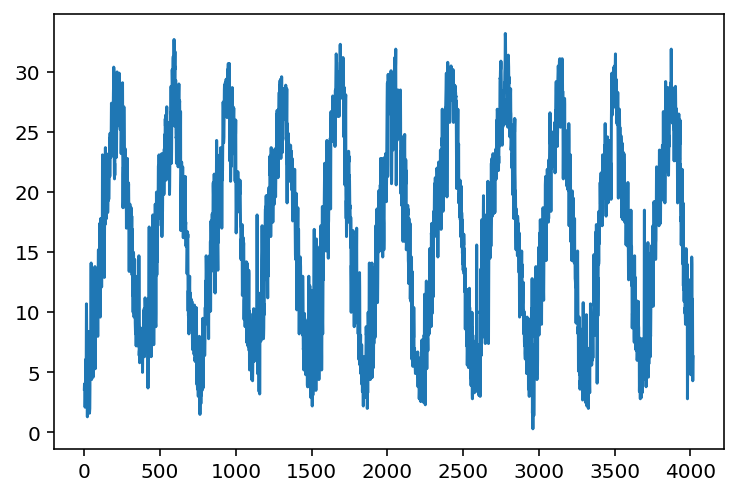

In [4]:
y = df["기온"].values
plt.plot(y)

In [5]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누는 예
ratio = 0.75
cut = np.int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 예측하는 것을 walk forward 예측이라고 한다

## 시계열 데이터를 테이블 구조로 만들기
- 시계열 예측에서 머신러닝 모델을 쉽게 적용하기 위해서 비정형인(크기가 일정치 않은) 시계열 데이터를 정형 데이터인 테이블 구조로 만드들어야 한다
- 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - data는 입력 시계열 데이터 (위 그림에서 len(data)=13임)
 - n_steps는 한 샘플의 크기 (위 그림에서 5)

In [6]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

In [7]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
data = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(data, 5)

pd.DataFrame(list(zip(x_train, y_train)), columns=['X','y'])

,X,y
0,"[1, 2, 3, 4, 5]",6
1,"[2, 3, 4, 5, 6]",7
2,"[3, 4, 5, 6, 7]",8
3,"[4, 5, 6, 7, 8]",9
4,"[5, 6, 7, 8, 9]",10
5,"[6, 7, 8, 9, 10]",11
6,"[7, 8, 9, 10, 11]",12
7,"[8, 9, 10, 11, 12]",13


## 선형 회귀 예측 모델 

In [8]:
# 선형 회귀 모델 함수
# from sklearn.linear_model import LinearRegression
model = LinearRegression()

# 과거 10일 기온 데이터를 사용하여 내일 기온을 예측하는 경우
n_steps = 10
# 훈련 데이터
x_train, y_train = split_seq(train_data, n_steps)
# 검증 데이터
x_test, y_test = split_seq(test_data, n_steps)
# 훈련 수행
model.fit(x_train, y_train) 
# 성능 평가: 회귀에서는 디폴트로 R-Squared 점수를 알려준다 (뒤에서 설명함)
model.score(x_test, y_test).round(4) 

0.936

In [65]:
x_train[:6], y_train[:6]

(array([[ 3.6,  4. ,  3.7,  4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3],
        [ 4. ,  3.7,  4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1],
        [ 3.7,  4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1,  6.1],
        [ 4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1,  6.1,  4. ],
        [ 3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1,  6.1,  4. ,  6.6],
        [ 2.1,  2.8,  4.2,  3.7,  4.3,  6.1,  6.1,  4. ,  6.6, 10.7]]),
 array([ 6.1,  6.1,  4. ,  6.6, 10.7,  9. ]))

In [9]:
# 실제값(y_test)과 예측값(y_pred) 비교
y_pred = model.predict(x_test)
pd.DataFrame({"y_test":y_test, "y_pred":y_pred.round(2)})[:5]

,y_test,y_pred
0,14.6,12.63
1,14.4,14.71
2,14.0,14.08
3,16.3,13.98
4,18.7,15.81


In [10]:
# 선형 예측 모델 계수 (가중치) - 가장 최근의 값에 곱해지는 계수가 가장 크다 (아래에서 마지막 계수)
model.coef_

array([ 0.04199142,  0.03098722,  0.00984958,  0.04929182,  0.03011167,
        0.04455212,  0.00230516,  0.11047411, -0.16003639,  0.82663927])

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [11]:
# 선형 회귀 예측의 여러가지 성능 평가 지표
# from sklearn.metrics import r2_score
def show_regression_result(y_test, y_pred, N=150):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("max error=", max(error).round(4))
    #  잔차  (residue) 산포도
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b*--', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

MAE= 1.4979
max error= 8.6136
R2= 0.936


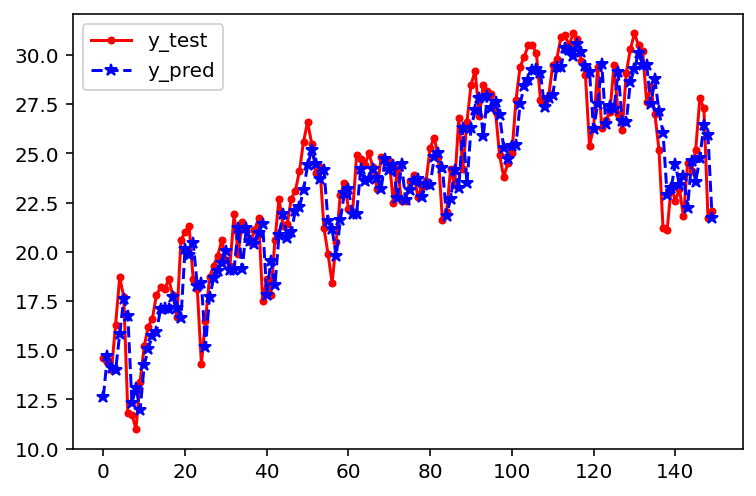

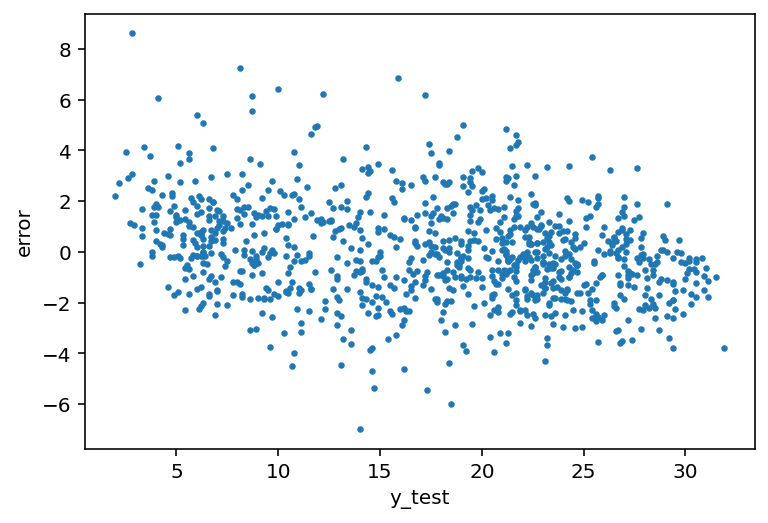

In [12]:
show_regression_result(y_test, y_pred)

# 베이스라인 모델
- 간단히 만들 수 있는 모델, 나이브 모델이라고도 한다
- 새로운 모델은 이것보다는 좋아야 하는 기준
- 종류
 - persistent 모델: 직전의 샘플 값으로 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다)
 - 직전 값들이 아니라 주기적인 일정 간격을 두고 샘플을 취하여 평균을 얻기도 한다

## persistent 모델

In [13]:
# 현재 값으로 다음 값을 예측하는 경우
x_test, y_test = split_seq(test_data, 1) 

In [14]:
x_test[:5], y_test[:5]

(array([[15.2],
        [13.8],
        [15.3],
        [11.4],
        [ 9. ]]),
 array([13.8, 15.3, 11.4,  9. , 11.4]))

MAE= 1.5846
max error= 10.4
R2= 0.9266


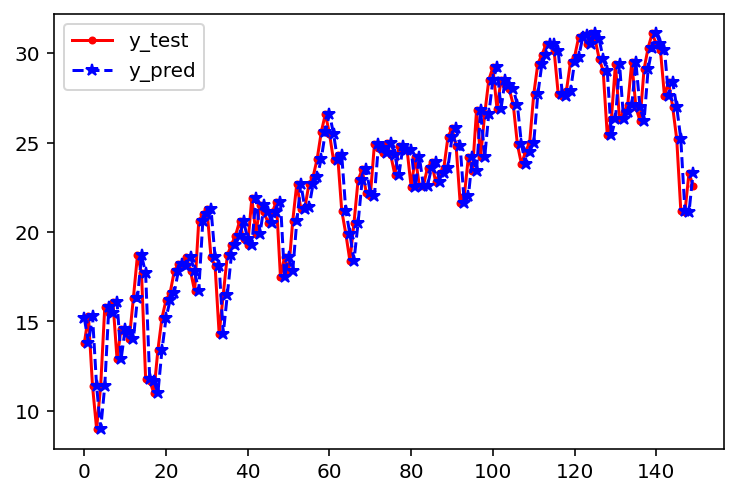

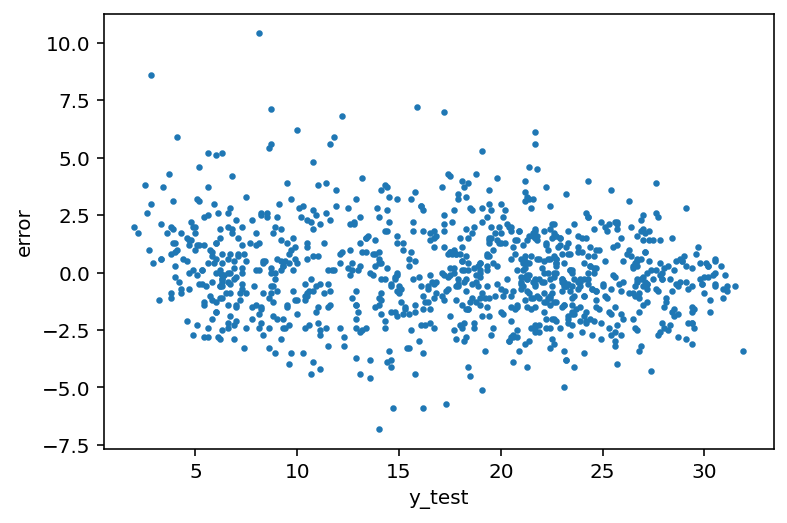

In [15]:
# 현재 값을 다음 예측값으로 사용
y_pred = x_test.ravel()
show_regression_result(y_test, y_pred)

## 과거의 평균치로 예측하는 경우

In [16]:
# 입력 데이터의 평균치를 리턴하는 함수
def average_model(seq):
    return np.array(seq).mean(axis=1)

In [17]:
# 평균할 갯수 최적의 찾기
result = {}
for i in range(1,20): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [18]:
result

{1: 0.9266,
 2: 0.9166,
 3: 0.9113,
 4: 0.9074,
 5: 0.9037,
 6: 0.901,
 7: 0.8991,
 8: 0.8982,
 9: 0.8971,
 10: 0.896,
 11: 0.8948,
 12: 0.8932,
 13: 0.8913,
 14: 0.8897,
 15: 0.888,
 16: 0.8861,
 17: 0.8841,
 18: 0.8812,
 19: 0.8778}

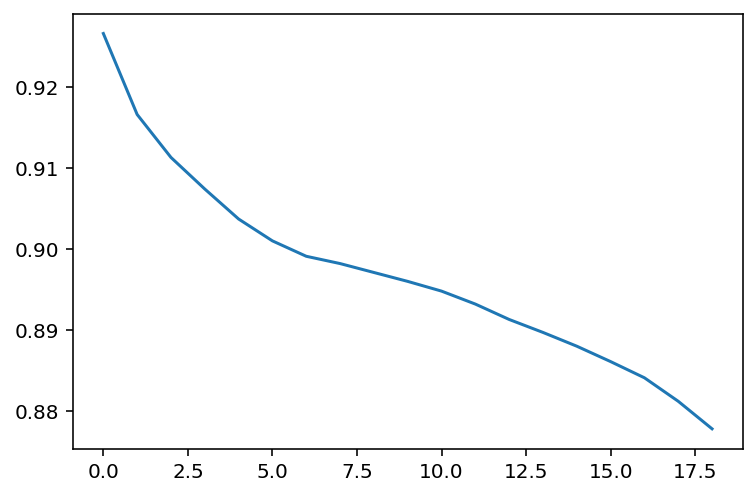

In [19]:
plt.plot(result.values())

In [106]:
max(result, key=result.get)

1

- 날씨 예측의 경우, 직전 값으로 예측하는 persistent 모델의 성능이 가장 좋다

## 멀티 스텝 예측

# (참고) Prophet 
- fbprophet을 설치해야 함
- colab에서 실행
- 날짜와 값을 포함하는 데이터프레임을 입력으로 사용한다
- 반드시 ['ds', 'y'] 이름의 컬럼명을 사용해야 한다

In [117]:
# !pip install pystan

In [118]:
# !conda install -c conda-forge fbprophet

In [120]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [23]:
df[:3]

,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


In [24]:
df = df.drop(["품질", "균질"], axis=1)

In [25]:
df.columns = ['ds', 'y']
df[:3]

,ds,y
0,2006/1/1,3.6
1,2006/1/2,4.0
2,2006/1/3,3.7


In [26]:
#datetime 포맷으로 바꾼다
df.ds = df.ds.apply(pd.to_datetime)

In [27]:
df.ds[:3]

0   2006-01-01
1   2006-01-02
2   2006-01-03
Name: ds, dtype: datetime64[ns]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4018 non-null   datetime64[ns]
 1   y       4018 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.9 KB


### 훈련, 검증 데이터 나누기

In [29]:
train = df[:3500]
test = df[3500:]
train.shape, test.shape

((3500, 2), (518, 2))

In [30]:
model = Prophet()
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# 예측할 기간의 날짜 정보가 필요하다
future_test = test.drop('y',axis=1);future_test

,ds
3500,2015-08-02
3501,2015-08-03
3502,2015-08-04
3503,2015-08-05
3504,2015-08-06
...,...
4013,2016-12-27
4014,2016-12-28
4015,2016-12-29
4016,2016-12-30


In [32]:
forecast = model.predict(future_test)

In [33]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-08-02,16.561539,25.089930,31.150037,16.561539,16.561539,11.497560,11.497560,11.497560,-0.108869,-0.108869,-0.108869,11.606428,11.606428,11.606428,0.0,0.0,0.0,28.059099
1,2015-08-03,16.560982,25.141071,31.120285,16.560982,16.560982,11.620111,11.620111,11.620111,-0.059070,-0.059070,-0.059070,11.679181,11.679181,11.679181,0.0,0.0,0.0,28.181093
2,2015-08-04,16.560424,25.435471,31.358071,16.560424,16.560424,11.800380,11.800380,11.800380,0.057071,0.057071,0.057071,11.743308,11.743308,11.743308,0.0,0.0,0.0,28.360803
3,2015-08-05,16.559866,25.370506,31.546380,16.559866,16.559866,11.826961,11.826961,11.826961,0.028758,0.028758,0.028758,11.798203,11.798203,11.798203,0.0,0.0,0.0,28.386827
4,2015-08-06,16.559309,25.289051,31.547858,16.559309,16.559309,11.862754,11.862754,11.862754,0.019394,0.019394,0.019394,11.843360,11.843360,11.843360,0.0,0.0,0.0,28.422063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,2016-12-27,16.275466,3.508473,9.515629,16.103311,16.433696,-9.730293,-9.730293,-9.730293,0.057071,0.057071,0.057071,-9.787365,-9.787365,-9.787365,0.0,0.0,0.0,6.545173
514,2016-12-28,16.274909,3.389781,9.299881,16.101847,16.433576,-9.873599,-9.873599,-9.873599,0.028758,0.028758,0.028758,-9.902357,-9.902357,-9.902357,0.0,0.0,0.0,6.401309
515,2016-12-29,16.274351,3.355420,9.346775,16.100322,16.433451,-9.992802,-9.992802,-9.992802,0.019394,0.019394,0.019394,-10.012196,-10.012196,-10.012196,0.0,0.0,0.0,6.281549
516,2016-12-30,16.273793,3.024025,9.181845,16.098825,16.433313,-10.031572,-10.031572,-10.031572,0.084984,0.084984,0.084984,-10.116555,-10.116555,-10.116555,0.0,0.0,0.0,6.242222


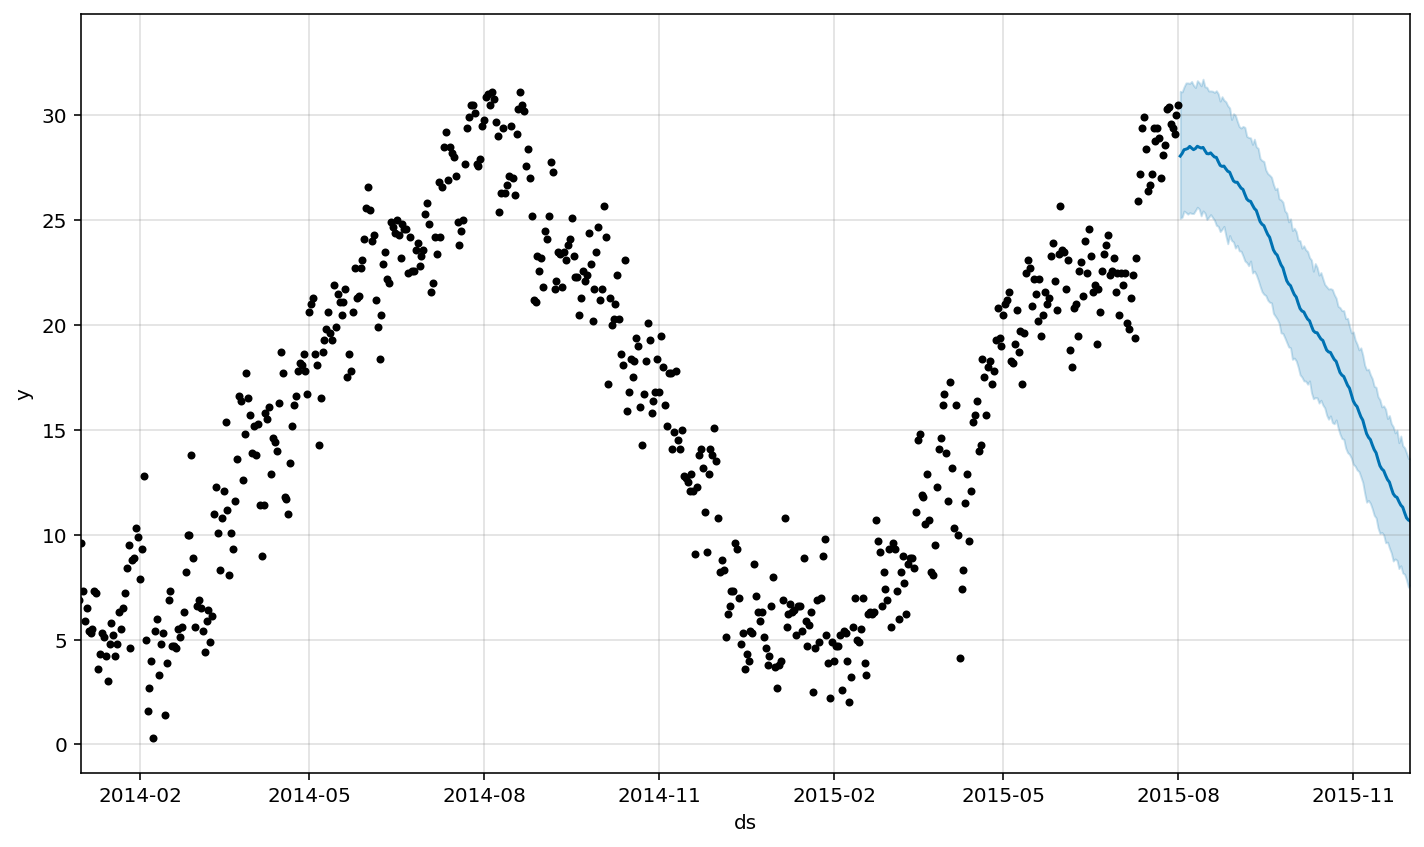

In [34]:
model.plot(forecast)
from datetime import datetime
plt.xlim([datetime(2014, 1, 1), datetime(2015, 12, 1)])
plt.show()

In [37]:
y_pred = forcast['yhat']
r2_score(y_test, y_pred)

0.8877830476016834